# Generate greedy answers
They are used to evaluate if answer is correct or incorrect. To see if an answer is correct/incorrect take fuzzy matching criterion $L(s, s') = \mathbb{1}_{\text{RougeL}(s, s') > 0.3}$ (page 7)


Structure:

```python 
{ 1131: {"greedy_answer": ..., 
         "rouge_l_score": ...
        }, 
  4295: ...
}
```
rouge_l_score stands for the Rouge-L score of the generated answer against the true answer. 

In [32]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, OPTForCausalLM, AutoModelForSequenceClassification
import yaml
import os
import pickle
from rouge_score import rouge_scorer
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.simplefilter(action='ignore', category=FutureWarning)

with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [33]:
# Load data
model_dir = config["model_dir"]
data_trivia = load_dataset("trivia_qa", "rc.nocontext")
data_trivia = data_trivia.remove_columns(["question_source", "entity_pages", "search_results"])
data_trivia_train = data_trivia["train"]
data_trivia_val = data_trivia["validation"]

Resolving data files:   0%|          | 0/26 [00:05<?, ?it/s]

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
checkpoint = config["checkpoint"]
tokenizer = AutoTokenizer.from_pretrained(f"facebook/{checkpoint}", cache_dir=model_dir)
model = OPTForCausalLM.from_pretrained(f"facebook/{checkpoint}", cache_dir=model_dir)
model = model.to(device)

In [5]:
selected_training_data = data_trivia_train.select(range(0, 10))
ten_shot_prompt = ""
for data in selected_training_data:
    ten_shot_prompt += "QUESTION:" + data["question"] + "ANSWER:" + data["answer"]["value"] + "\n"

# Define stop tokens, use token on position 1 bc position 0 is special token
stop_tokens = ["Q:", "Question:", "QUESTION:", "questions:", " Q:", " Question:", " QUESTION:", " questions:",
               "A:", "Answer:", "ANSWER:", "answers:", " A:", " Answer:", " ANSWER:", " answers:", "Answers:",
               " Answers:",
               "Topic:", " Topic:", "TOPIC:", " TOPIC:", ".", " .", "...", " ...", "?", " ?", ":", " :", "!", " !"]
stop_tokens = [[tokenizer(stop_token)["input_ids"][1]] for stop_token in stop_tokens]

# Define eos token
eos_token = tokenizer("\n")["input_ids"][1]
tokenizer.pad_token_id = eos_token
tokenizer.eos_token_id = eos_token

# Maximum token length that generated answer can have
max_new_tokens = config["max_output_length"]

In [35]:
save_path = config["path_to_saved_generations"]
with open(os.path.join(save_path, "group_indices.txt"), "r") as f:
    indices_questions = {int(i) for line in f for i in line.strip().split(",")}

In [7]:
# https://thepythoncode.com/article/calculate-rouge-score-in-python#rouge-l
scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

In [25]:
if os.path.exists(os.path.join(save_path, "greedy_answers.pkl")):
    with open(os.path.join(save_path, "greedy_answers.pkl"), "rb") as f:
        result = pickle.load(f)
else:
    result = dict()

for idx in tqdm(indices_questions):
    if idx in result:
        print(f"Question {idx} already exists. Skipping...")

    result_question = dict()
    question = ten_shot_prompt + "QUESTION:" + data_trivia_val[idx]["question"] + "ANSWER:"
    answer = data_trivia_val[idx]["answer"]["value"]

    inputs = tokenizer(question, padding=False, truncation=False, return_tensors="pt").to(device)
    length_input = inputs["input_ids"].shape[1]

    # Generate sequence by always taking token with max probability (greedy)
    output_generate = model.generate(inputs.input_ids,
                                     max_new_tokens=max_new_tokens,
                                     eos_token_id=eos_token,
                                     bad_words_ids=stop_tokens)

    output = tokenizer.batch_decode(output_generate[0][length_input:], skip_special_tokens=True)
    output = "".join(output).replace("\n", "")
    result_question["greedy_answer"] = output
    rouge_l_score = scorer.score(answer, output)["rougeL"].fmeasure
    result_question["rouge_l_score"] = rouge_l_score
    result[idx] = result_question

    # Save new dictionary
    with open(os.path.join(save_path, "greedy_answers.pkl"), "wb") as f:
        pickle.dump(result, f)

100%|██████████| 4484/4484 [14:25<00:00,  5.18it/s]


## Analyze Rouge-L-Score

In [8]:
with open(os.path.join(save_path, "greedy_answers.pkl"), "rb") as f:
    greedy_answers = pickle.load(f)

greedy_answers = pd.DataFrame.from_dict(greedy_answers, orient="index")
greedy_answers.index.name = "question_id"
greedy_answers.reset_index(inplace=True)

# Add question and true answers to df
greedy_answers["question"] = greedy_answers["question_id"].apply(lambda idx: data_trivia_val[idx]["question"])
greedy_answers["true_answer"] = greedy_answers["question_id"].apply(lambda idx: data_trivia_val[idx]["answer"]["value"])

The distribution of ROUGE-L scores across the generated answers, can be seen in this plot:

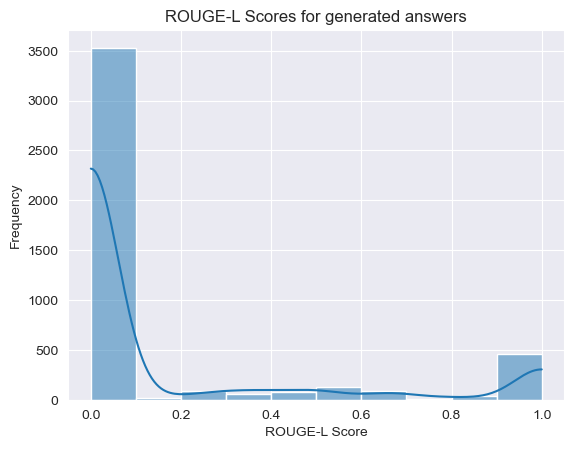

In [9]:
# Plot distribution
sns.histplot(greedy_answers["rouge_l_score"], bins=10, kde=True)
plt.title("ROUGE-L Scores for generated answers")
plt.xlabel("ROUGE-L Score")
plt.ylabel("Frequency")
plt.show()

ROUGE-L Score is based on the length of the longest common subsequence
- If score is 1 --> Perfect score --> One can be sure that answer is correct
- In the paper, it is stated that if the ROUGE-L Score is > 0.3 an answer is seen as correct. 

In [10]:
answers_exact_match = greedy_answers[greedy_answers["rouge_l_score"] == 1]
print(f"There are {len(answers_exact_match)} answers that are the exact same as the reference answer. Examples:")
answers_exact_match.head(3)

There are 462 answers that are the exact same as the reference answer. Examples:


,question_id,greedy_answer,rouge_l_score,question,true_answer
4,8196,Magma,1.0,"What name is given to the hot, molten rock fou...",MAGMA
17,8216,Dar es Salaam,1.0,What was the capital city of Tanzania until 1974?,DAR-ES-SALAAM
20,16413,Family Guy,1.0,The father of three 'Peter Griffin' is the tit...,'FAMILY GUY'


When evaluating the samples with a ROUGE-L score < 1, saying that the answer is correct if the ROUGE-L score is > 0.3 seems to be a good measure for the majority of samples, there are however cases that would get misclassified.

**Examples of False negatives:**

In [11]:
greedy_answers.loc[greedy_answers["question_id"].isin([129, 16742, 4482, 7061])]

,question_id,greedy_answer,rouge_l_score,question,true_answer
100,129,basketball,0.000000,The Naismith Award is presented in which sport?,Basket ball
257,16742,The olfactory bulb is located in the nose,0.222222,Where in the human body can you find the 'Olfa...,NOSE
2670,4482,On the bottom of the foot,0.285714,Where would you find the metatarsal bone?,Foot
3933,7061,"Jimmi Hendrix was 27, Janis Joplin was 27 and ...",0.142857,"How old were Jimmi Hendrix, Janis Joplin and J...",27


**Examples of False positives:**

There are more false positives, often due to stop words like "and" or common first names.

In [12]:
greedy_answers.loc[greedy_answers["question_id"].isin([16458, 132, 321, 8585, 8630, 4421])]


,question_id,greedy_answer,rouge_l_score,question,true_answer
57,16458,Paul Gallen,0.500000,Who is the only Rugby League player to win two...,Paul Wellens
106,132,The Graduate,0.333333,What was Warren Beatty's first movie?,Splendor in the Grass
235,321,The Grapes,0.400000,What is the most common pub name in the UK?,The Red Lion
290,8585,St Thomas',0.400000,"Rahere, an Anglo-Norman monk, founded which Lo...",St Bartholomew's
329,8630,The Graduate,0.500000,For which 1960 film did Billy Wilder become th...,The Apartment
2640,4421,The Australian Open,0.666667,What is the last Grand Slam tennis tournament ...,The US Open


On page 17, they show that the choice of accuracy metric has almost no effect on the measured AUROC of the uncertainty estimation when using TriviaQA. To reproduce this results, I also calculate the Rouge-1 measure:

In [70]:
with open(os.path.join(save_path, "greedy_answers.pkl"), "rb") as f:
    greedy_answers_infer = pickle.load(f)

In [71]:
scorer = rouge_scorer.RougeScorer(["rouge1"], use_stemmer=True)

In [72]:
for idx in greedy_answers_infer.keys():
    answer = data_trivia_val[idx]["answer"]["value"]
    generated_answer = greedy_answers_infer[idx]["greedy_answer"]
    rouge_1_score = scorer.score(answer, generated_answer)["rouge1"].fmeasure
    greedy_answers_infer[idx]["rouge_1_score"] = rouge_1_score

    # Save new dictionary
    with open(os.path.join(save_path, "greedy_answers.pkl"), "wb") as f:
        pickle.dump(greedy_answers_infer, f)

However, note that there are only a few cases where ROUGE-1 != ROUGE-L:

In [37]:
with open(os.path.join(save_path, "greedy_answers.pkl"), "rb") as f:
    greedy_answers_infer = pickle.load(f)

n_cases = 0
for i in greedy_answers_infer:
    if greedy_answers_infer[i]["rouge_l_score"] != greedy_answers_infer[i]["rouge_1_score"]:
        n_cases += 1
print(f"Number of cases: {n_cases}")

Number of cases: 9


## Try out entailment
The advantage of this approach would be that also semantically equivalent answers would be recognized as being correct. For more info on entailment, see `infer_answers.ipynb`.

In [36]:
model_name = "sileod/deberta-v3-large-tasksource-nli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

In [37]:
with open(os.path.join(save_path, "greedy_answers.pkl"), "rb") as f:
    greedy_answers = pickle.load(f)

In [42]:
for question_idx in tqdm(greedy_answers.keys()):
    true_answer = "Answer: " + data_trivia_val[question_idx]["answer"]["value"]
    question = "Question: " + data_trivia_val[question_idx]["question"]
    generated_answer = "Answer: " + greedy_answers[question_idx]["greedy_answer"]
    
    entail = False

    # First direction
    premise = question + " " + generated_answer
    hypothesis = question + " " + true_answer
    input = tokenizer(premise, hypothesis, return_tensors="pt")
    output = model(input["input_ids"].to(device))
    prediction = torch.argmax(output["logits"][0], dim=-1).item()  # 0: entail, 1: neutral, 2: contradiction

    # Only if first direction entailment: look at second direction
    if prediction == 0:
        input = tokenizer(hypothesis, premise, return_tensors="pt")
        output = model(input["input_ids"].to(device))
        prediction = torch.argmax(output["logits"][0], dim=-1).item()
        if prediction == 0:
            entail = True
    
    greedy_answers[question_idx]["result_entail"] = entail
    
    # Save 
    with open(os.path.join(save_path, "greedy_answers.pkl"), "wb") as f:
        pickle.dump(greedy_answers, f)

100%|██████████| 4484/4484 [12:12<00:00,  6.12it/s] 


## Manually label by hand
To account for FP and FN, I also label the generated questions by hand to be able to then compare the results to the ROUGE metrics and the entailment result:

In [43]:
with open(os.path.join(save_path, "greedy_answers.pkl"), "rb") as f:
    greedy_answers_infer = pickle.load(f)

In [44]:
# variable input used
if "input" in globals():
    del input

for idx in greedy_answers_infer.keys():
    if "label_by_hand" in greedy_answers_infer[idx]:
        # print(f"{idx} already exists. Skipping...")
        continue

    question = data_trivia_val[idx]["question"]
    answer = data_trivia_val[idx]["answer"]["value"]
    generated_answer = greedy_answers_infer[idx]["greedy_answer"]
    so_far = greedy_answers_infer[idx]["rouge_l_score"] > 0.5

    # Print the question, answer, and generated answer
    print(f"Question: {question}")
    print(f"Answer: {answer}")
    print(f"Generated Answer: {generated_answer}")

    # Prompt the user for input
    user_input = False
    while user_input not in ["", "1", "0"]:
        user_input = input(
            f"{idx}) {question}\n{answer}\n{generated_answer}\nSo far: {so_far}\nCorrect? (then input nothing), otherwise 1 for true, 0 for false: ")

    # Save the input as 1 (true) or 0 (false)
    label_by_hand = so_far if user_input == "" else int(user_input)
    greedy_answers_infer[idx]["label_by_hand"] = label_by_hand

    print()
    # Save new dictionary
    with open(os.path.join(save_path, "greedy_answers.pkl"), "wb") as f:
        pickle.dump(greedy_answers_infer, f)

## Evaluate correctness scores
In the notebook `diversity_answers.ipynb` the correctness of an answer also needs to be evaluated. As doing this by hand is too cumbersome, but I already have them in this case, the approximations
- Rouge-L(s, s') > 0.3
- Rouge-L(s, s') > 0.5
- Rouge-1(s, s') > 0.5
- Entailment

are evaluated and the best one is picked.

In [64]:
with open(os.path.join(save_path, "greedy_answers.pkl"), "rb") as f:
    greedy_answers = pickle.load(f)

In [65]:
y_true = []
y_rouge_l_03 = []
y_rouge_l_05 = []
y_rouge_1_05 = []
y_entailment = []
for value in greedy_answers.values():
    y_true.append(value["label_by_hand"])
    y_rouge_l_03.append(value["rouge_l_score"] > 0.3)
    y_rouge_l_05.append(value["rouge_l_score"] > 0.5)
    y_rouge_1_05.append(value["rouge_1_score"] > 0.5)
    y_entailment.append(value["result_entail"])

confusion_matrix_rouge_l_03 = confusion_matrix(y_true, y_rouge_l_03)
confusion_matrix_rouge_l_05 = confusion_matrix(y_true, y_rouge_l_05)
confusion_matrix_rouge_1_05 = confusion_matrix(y_true, y_rouge_1_05)
confusion_matrix_entailment = confusion_matrix(y_true, y_entailment)

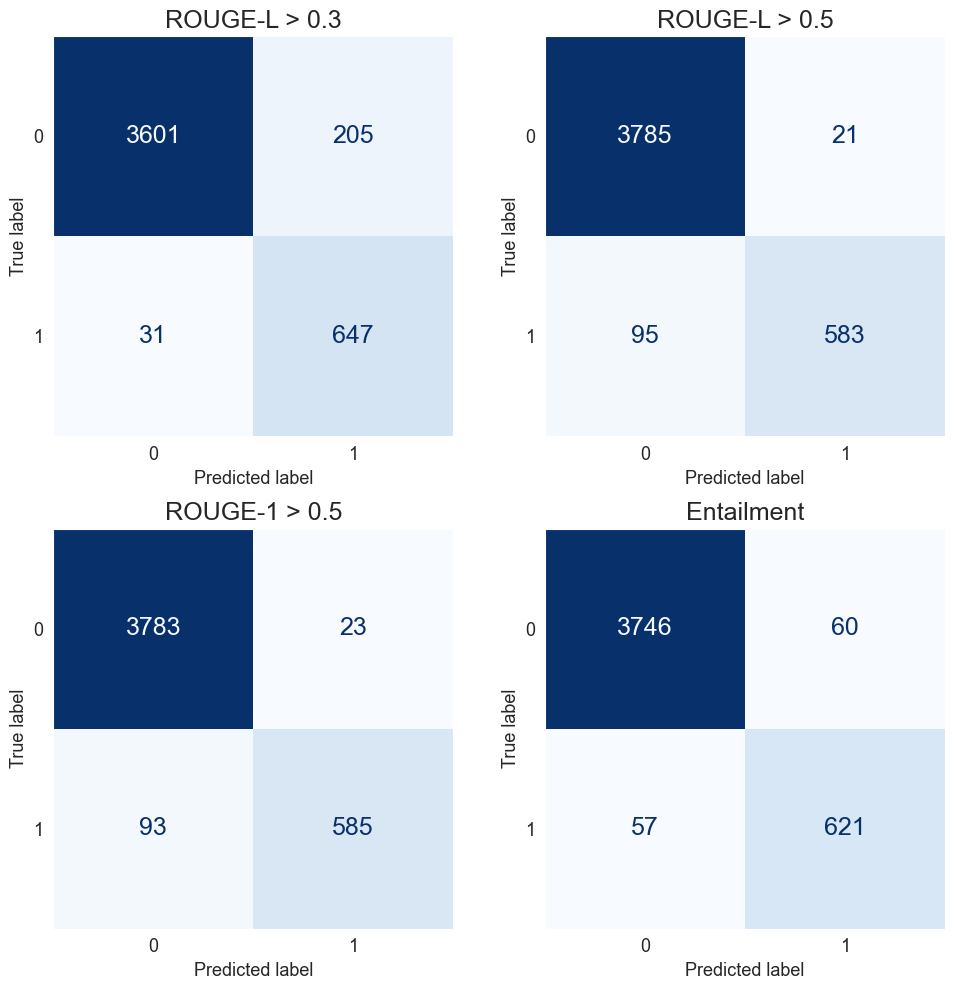

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10)) 

def plot_confusion_matrix(ax, confusion_matrix, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    disp.plot(ax=ax, cmap="Blues", colorbar=False) 
    ax.set_title(title, fontsize=18)
    ax.grid(False)
    ax.tick_params(axis="both", which="major", labelsize=13)
    for t in disp.text_.ravel():
        t.set_fontsize(18)   
    ax.set_xlabel("Predicted label", fontsize=13)
    ax.set_ylabel("True label", fontsize=13)

plot_confusion_matrix(axes[0][0], confusion_matrix_rouge_l_03, "ROUGE-L > 0.3")
plot_confusion_matrix(axes[0][1], confusion_matrix_rouge_l_05, "ROUGE-L > 0.5")
plot_confusion_matrix(axes[1][0], confusion_matrix_rouge_1_05, "ROUGE-1 > 0.5")
plot_confusion_matrix(axes[1][1], confusion_matrix_entailment, "Entailment")

plt.tight_layout()
plt.show()

One problem for entailment is that the generated answer sometimes contains too much information. For instance, if the question is "In what year ..." the true answer is just the year, but the generated answer is the exact date. This is then not seen as a bidirectional entailment. One can argue if too precise answers are correct or not. I have labeled them as being correct, however if being strict, they don't answer the question to 100% correct (in the sense of, the question only asks for the year/first name/... and not more information).

ROUGE-L > 0.5 and ROUGE-1 > 0.5 have the same number of correctly identified answers. 

Since the actual goal of the paper is to incorporate that answers can have a different lexical/syntactical form, but still be semantically equivalent, I will use this score to evaluate the correctness of answers in the notebook `diversity_answers.ipynb`. To also do exactly the same as the paper, I also plot the same for ROUGE-L > 0.3 (however, in my setting it is not a good measure).